# **Hypothesis Test and Regression Analysis**

This notebook focuses on some statistical and regression analysis and tries to find the answers to the following questions:

- How significantly does the **Conversion Rate** and **Return on Investment (ROI)** differ across different **marketing strategies**?
- Which factors contribute the most to **Conversion Rate** and **Return on Investment (ROI)**?  
- How strongly do different variables influence **Conversion Rate** and **ROI**?

# **Read Data from BigQuery**

In [ ]:
# Libraries we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from google.cloud import bigquery
from google.colab import auth

# Authenticate
auth.authenticate_user()

# Initialize the client for BigQuery
project_id = 'marketing-campaign-449808'
client = bigquery.Client(project=project_id, location='US')

# Get the dataset
dataset_ref = client.dataset(dataset_id='campaign_data', project=project_id)
dataset = client.get_dataset(dataset_ref=dataset_ref)

# Get the table
main_table_ref = dataset.table('marketing_campaign_dataset')
main_table = client.get_table(main_table_ref)

# convert to dataframe
df = client.list_rows(table = main_table).to_dataframe()
df.head()

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration_Days,Channel_Used,Conversion_Rate,Acquisition_Cost_dollars,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Year,Month
0,2921,Alpha Innovations,Influencer,Women 25-34,45,Facebook,0.09,10950.0,6.22,Chicago,English,779,3433,1,Foodies,2021-01-01,2021,January
1,14236,TechCorp,Email,Women 35-44,30,Google Ads,0.07,19789.0,7.01,Houston,German,543,9792,1,Tech Enthusiasts,2021-01-01,2021,January
2,22996,NexGen Systems,Search,Men 25-34,60,Instagram,0.07,11033.0,6.55,New York,English,563,4355,1,Fashionistas,2021-01-01,2021,January
3,24091,Innovate Industries,Search,Men 18-24,60,Email,0.08,16619.0,4.29,New York,French,796,6013,1,Fashionistas,2021-01-01,2021,January
4,27011,Innovate Industries,Social Media,Men 25-34,60,Facebook,0.07,15412.0,2.44,New York,French,847,4625,1,Fashionistas,2021-01-01,2021,January


# **Hypothesis Test**

In [ ]:
!pip install scikit-posthocs

### **Create the Functions to Perform the Tests**

Flow of the test is as follows:

1. **Check Normality** (Shapiro-Wilk or Kolmogorov-Smirnov Test)  
   - If **all groups are normal** → Proceed to **Levene’s Test**  
   - If **all groups are non-normal** → Use **Non-Parametric Tests**  
   - If **mixed normality** → Use **Kruskal-Wallis or Welch’s ANOVA**  

2. **Check Variance Homogeneity** (Levene’s Test)  
   - If **variances are equal** → Use **Independent T-Test (2 groups) or One-Way ANOVA (>2 groups)**  
   - If **variances are NOT equal** → Use **Welch’s T-Test (2 groups) or Welch’s ANOVA (>2 groups)**  

3. **Perform Parametric or Non-Parametric Test**  
   - If **parametric** (normal & equal variances)  
     - **2 groups** → Independent T-Test  
     - **>2 groups** → One-Way ANOVA  
   - If **parametric** (normal & unequal variances)  
     - **2 groups** → Welch’s T-Test  
     - **>2 groups** → Welch’s ANOVA  
   - If **non-parametric** (not normal)  
     - **2 groups** → Mann-Whitney U Test  
     - **>2 groups** → Kruskal-Wallis Test  

4. **Post-hoc Analysis (pairwise test between the groups, one type of summary of the whole tests)**  
   - If **parametric & equal variances** → Use **Tukey’s HSD Test**  
   - If **parametric & unequal variances** → Use **Games-Howell Test**  
   - If **non-parametric** → Use **Dunn’s Test**

In [ ]:
# Required libraries for statistical tests
from scipy import stats
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp


def normality_check(*data_groups, alpha=0.05, group_names=None, test_type="shapiro"):
    """
    Perform a normality test on multiple datasets using the Shapiro-Wilk or Kolmogorov-Smirnov test.

    Parameters:
    - data_groups: Multiple datasets (arrays or lists) to test for normality.
    - alpha (float): Significance level (default 0.05). Used to determine normality.
    - group_names (list, optional): Names for the datasets. Defaults to "Group 1", "Group 2", etc.
    - test_type (str): "shapiro" (default) for Shapiro-Wilk or "ks" for Kolmogorov-Smirnov test.

    Outputs:
    - Prints the test results, including test statistic and p-value for each dataset.
    - Provides guidance on whether to use parametric (e.g., ANOVA) or non-parametric (e.g., Kruskal-Wallis) tests.

    Notes:
    - The Shapiro-Wilk test is not recommended for large sample sizes (>5000).
    - The Kolmogorov-Smirnov test assumes data is compared to a normal distribution.
    """

    if group_names is None:
        group_names = [f"Group {i+1}" for i in range(len(data_groups))]

    results = []
    for i, data in enumerate(data_groups):
        if len(data) > 5000 and test_type == "shapiro":
            print(f"Warning: Sample size for {group_names[i]} is large (>5000). Consider using the Kolmogorov-Smirnov (KS) test instead.")

        if test_type == "shapiro":
            stat, p = stats.shapiro(data)
            test_name = "Shapiro-Wilk Test"
        elif test_type == "ks":
            stat, p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
            test_name = "Kolmogorov-Smirnov Test"
        else:
            print(f"Error: Unsupported test_type '{test_type}'. Use 'shapiro' or 'ks'.")
            return

        results.append((group_names[i], p))
        print(f"{test_name} for {group_names[i]}: Test Statistic = {stat:.4f}, P-Value = {p}")

    # Determine next steps
    non_normal_groups = [name for name, p in results if p < alpha]
    normal_groups = [name for name, p in results if p >= alpha]

    if len(non_normal_groups) == len(data_groups):
        print("All groups are non-normal. Use Mann-Whitney U (if 2 groups) or Kruskal-Wallis (if >2 groups).")
    elif len(normal_groups) == len(data_groups):
        print("All groups are normal. Proceed to Levene’s Test for variance homogeneity.")
    else:
        print(f"Mixed results: Normal - {normal_groups}, Non-Normal - {non_normal_groups}. Use Kruskal-Wallis or Welch’s ANOVA.")




def levene_test(*data_groups, center, alpha=0.05, group_names=None):
    """
    Perform Levene's test to assess the homogeneity of variances across multiple datasets.

    Parameters:
    - data_groups: Multiple datasets (arrays or lists) to test for equal variances.
    - center (str): Method for calculating center. Use "mean" for normal data and "median" for non-normal data.
    - alpha (float): Significance level (default 0.05).
    - group_names (list, optional): Names for the datasets. Defaults to "Group 1", "Group 2", etc.

    Outputs:
    - Prints the test statistic and p-value.
    - Provides recommendations on using parametric (e.g., One-Way ANOVA) or non-parametric (e.g., Welch’s ANOVA) tests.

    Notes:
    - If p > alpha, variances are equal (homogeneous), and standard ANOVA or T-tests can be used.
    - If p < alpha, variances are unequal (heterogeneous), and Welch’s tests should be used instead.
    """

    if group_names is None:
        group_names = [f"Group {i+1}" for i in range(len(data_groups))]

    stat, p = stats.levene(*data_groups, center=center)
    print(f"Levene’s Test Statistic = {stat:.4f}, P-Value = {p}")

    if p > alpha:
        print("Variances are equal. Use Independent T-Test (for 2 groups) or One-Way ANOVA (for >2 groups).")
    else:
        print("Variances are NOT equal. Use Welch’s T-Test (for 2 groups) or Welch’s ANOVA (for >2 groups).")




def parametric_test(*data_groups, alpha=0.05, equal_var=None, group_names=None):
    """
    Conduct parametric statistical tests: Independent T-Test (for 2 groups) or ANOVA (for >2 groups).

    Parameters:
    - data_groups: Multiple datasets (arrays or lists) to compare.
    - alpha (float): Significance level (default 0.05).
    - equal_var (bool, optional): Assumption of equal variances. If None, it is determined using Levene’s test.
    - group_names (list, optional): Names for the datasets. Defaults to "Group 1", "Group 2", etc.

    Outputs:
    - Prints the test statistic, p-value, and interpretation.
    - Recommends post-hoc tests (pairwise test) if significant differences are found.

    Notes:
    - If only two groups are compared:
      - Uses Welch’s T-Test if variances are unequal.
      - Uses Independent T-Test if variances are equal.
    - If more than two groups:
      - Uses One-Way ANOVA if variances are equal.
      - Uses Welch’s ANOVA if variances are unequal.
    """

    if group_names is None:
        group_names = [f"Group {i+1}" for i in range(len(data_groups))]

    # Auto-detect equal variance if not specified
    if equal_var is None and len(data_groups) > 1:
        stat, p_var = stats.levene(*data_groups)  # Levene’s test for equal variance
        equal_var = p_var > alpha  # True if variances are equal

    if len(data_groups) == 2:
        test_name = "Welch’s T-Test" if not equal_var else "Independent T-Test"
        stat, p = stats.ttest_ind(*data_groups, equal_var=equal_var)

    else:  # More than 2 groups
        if equal_var:
            test_name = "One-Way ANOVA"
            stat, p = stats.f_oneway(*data_groups)  # Regular ANOVA
        else:
            test_name = "Welch’s ANOVA"
            anova_result = anova_oneway(data_groups, use_var="unequal")  # Welch’s ANOVA
            stat, p = anova_result.statistic, anova_result.pvalue

    print(f"{test_name} Statistic = {stat:.4f}, P-Value = {p}")

    if p < alpha:
        print(f"Significant difference found (P < {alpha}). Proceed with post-hoc tests (pairwise test).")
    else:
        print(f"No significant difference (P > {alpha}).")




def non_parametric_test(*data_groups, alpha=0.05, group_names=None):
    """
    Conduct non-parametric statistical tests: Mann-Whitney U Test (for 2 groups) or Kruskal-Wallis Test (for >2 groups).

    Parameters:
    - data_groups: Multiple datasets (arrays or lists) to compare.
    - alpha (float): Significance level (default 0.05).
    - group_names (list, optional): Names for the datasets. Defaults to "Group 1", "Group 2", etc.

    Outputs:
    - Prints the test statistic, p-value, and interpretation.
    - Recommends post-hoc analysis (Dunn’s test) if a significant difference is detected.

    Notes:
    - The Mann-Whitney U test assumes independent samples and similar distributions.
    - The Kruskal-Wallis test is a non-parametric alternative to One-Way ANOVA.
    - Dunn’s test with Bonferroni correction is recommended for post-hoc analysis.
    """

    if group_names is None:
        group_names = [f"Group {i+1}" for i in range(len(data_groups))]

    if len(data_groups) == 2:
        stat, p = stats.mannwhitneyu(*data_groups, alternative='two-sided')
        test_name = "Mann-Whitney U Test"
    else:
        stat, p = stats.kruskal(*data_groups)
        test_name = "Kruskal-Wallis Test"

    print(f"{test_name} Statistic = {stat:.4f}, P-Value = {p}")

    if p < alpha:
        print(f"Significant difference found (P < {alpha}).")
    else:
        print(f"No significant difference detected (P > {alpha}).")




def pairwise_test(target_column, groups, alpha=0.05, no_parametric=False):
    """
    Perform post-hoc pairwise comparisons after ANOVA or Kruskal-Wallis tests.

    Parameters:
    - target_column (array-like): Numeric data (dependent variable).
    - groups (array-like): Categorical labels indicating group membership.
    - alpha (float): Significance level (default 0.05).
    - no_parametric (bool): If True, perform Dunn’s test for non-parametric data.

    Returns:
    - DataFrame containing pairwise comparisons and adjusted p-values.

    Outputs:
    - Prints test results and provides recommendations based on variance homogeneity.

    Notes:
    - Uses Tukey’s HSD test if variances are equal.
    - Uses Games-Howell test if variances are unequal.
    - Uses Dunn’s test for non-parametric comparisons.
    - At least 3 groups are required for post-hoc testing.
    """

    unique_groups = np.unique(groups)

    if len(unique_groups) < 3:
        print("Warning: At least 3 groups are required for post-hoc tests.")
        return None

    # Convert target_column and groups into grouped data for post-hoc tests
    data_groups = [target_column[groups == g] for g in unique_groups]

    if no_parametric:
        # Perform Dunn’s post-hoc test with Bonferroni correction
        print("Using Dunn’s Post-Hoc Test (non-parametric).")
        posthoc_results = sp.posthoc_dunn(data_groups, p_adjust='bonferroni')

        # Convert results into DataFrame with proper labels and reset index
        posthoc_df = pd.DataFrame(posthoc_results.values, index=unique_groups, columns=unique_groups)
        posthoc_df = posthoc_df.reset_index().rename(columns={"index": "Campaigns"})

        print("Dunn’s Post-Hoc Test Results (Adjusted P-Values):")
        print(posthoc_df)
        return posthoc_df  # Ensure proper return of Dunn's test results

    # Levene’s test checks for equal variances
    stat, p_var = stats.levene(*data_groups)

    if p_var > alpha:
        print("Using Tukey’s HSD test (equal variances assumed).")
        tukey = pairwise_tukeyhsd(endog=target_column, groups=groups, alpha=alpha)
        print(f"Tukey HSD Test Results:\n{tukey}")

        tukey.plot_simultaneous()
        plt.title("Tukey HSD Test Results")
        plt.show()

        tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
        tukey_df = tukey_df.rename(columns={"group1": "Campaigns", "group2": "Compared To"})  # Renaming columns

        return tukey_df

    else:
        print("Variances are unequal (Levene’s test P < alpha). Using Games-Howell test.")
        games_howell = sp.posthoc_gameshowell(
            data=pd.DataFrame({"target": target_column, "group": groups}),
            val_col="target",
            group_col="group",
            p_adjust="holm"
        )

        # Reset index and rename it to "Campaigns"
        games_howell = games_howell.reset_index().rename(columns={"index": "Campaigns"})

        print("Games-Howell Test Results:\n", games_howell)
        return games_howell

### **Distribution of Conversion Rate and Return of Investment**

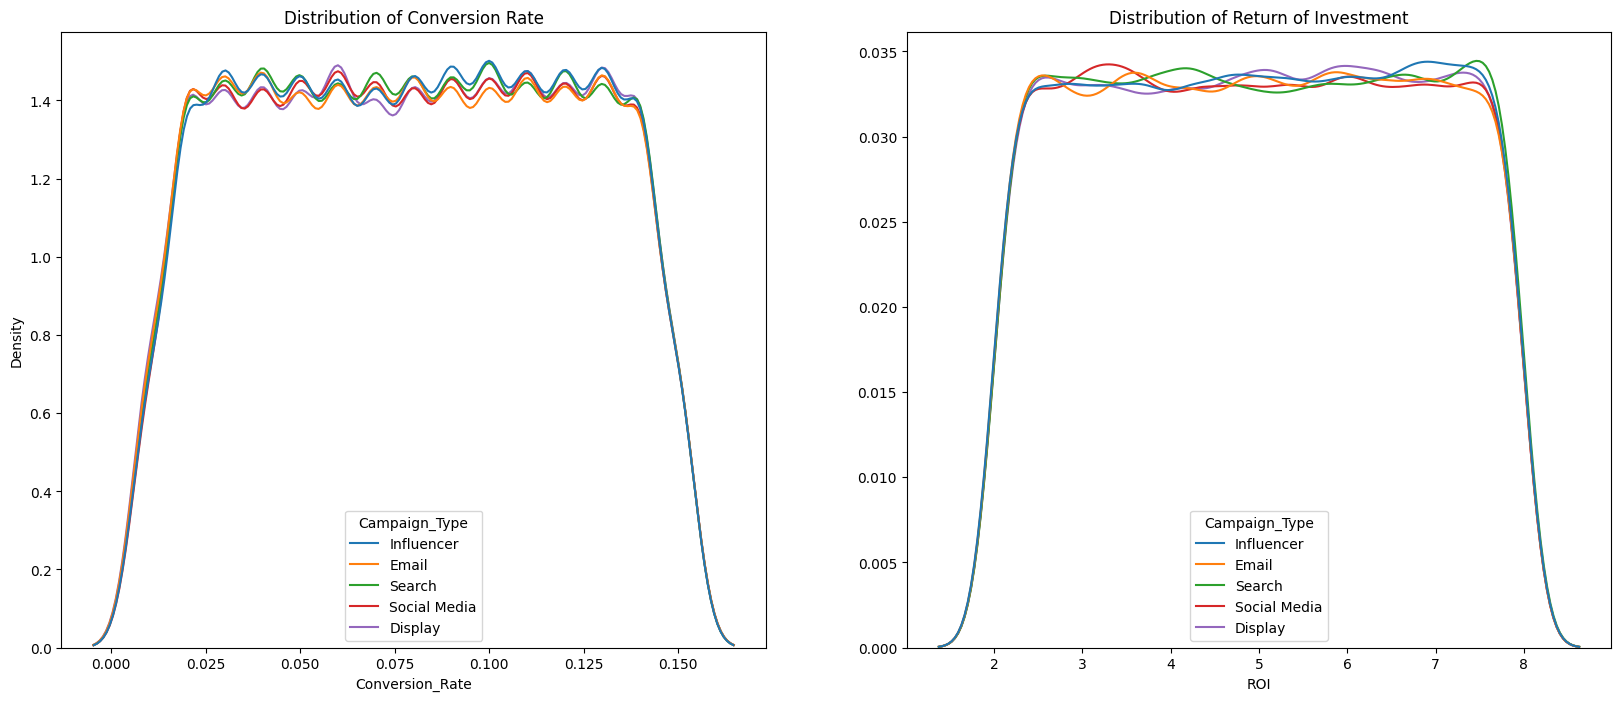

In [ ]:
# See the distribution of Conversion_Rate and ROI based on each Campaign_Type
fig, ax = plt.subplots(1, 2, figsize = (20, 8))

sns.kdeplot(data = df, x = 'Conversion_Rate', hue = 'Campaign_Type', ax = ax[0])
ax[0].set_title("Distribution of Conversion Rate")

sns.kdeplot(data = df, x = 'ROI', hue = 'Campaign_Type', ax = ax[1])
ax[1].set_title("Distribution of Return of Investment")
ax[1].set_ylabel('')

plt.show()

The left plot shows the **distribution of conversion rates** across different campaign types, with all distributions appearing nearly identical. The right plot depicts the **distribution of ROI**, where the campaign types also exhibit highly similar patterns. Both distributions suggest minimal variation between campaign types. Both plots show **un-smooth but approximately symmetric distributions** without heavy skewness, suggesting the data appears **approximately not normal** for both **conversion rate** and **ROI** across campaign types.

In [ ]:
list(df['Campaign_Type'].unique())

['Influencer', 'Email', 'Search', 'Social Media', 'Display']

### **Test on Conversion Rate**

- **Null Hypothesis (H₀):** There is **no significant difference** in the **conversion rate** across different campaign types.  
- **Alternative Hypothesis (H₁):** There is a **significant difference** in the **conversion rate** among at least one of the campaign types.

In [ ]:
# Separate the groups based on the type of campaigns with conversion rate
influencer_camp_cr = df[df['Campaign_Type'] == 'Influencer']['Conversion_Rate']
email_camp_cr = df[df['Campaign_Type'] == 'Email']['Conversion_Rate']
search_camp_cr = df[df['Campaign_Type'] == 'Search']['Conversion_Rate']
social_media_camp_cr = df[df['Campaign_Type'] == 'Social Media']['Conversion_Rate']
display_camp_cr = df[df['Campaign_Type'] == 'Display']['Conversion_Rate']

influencer_camp_cr.shape[0], email_camp_cr.shape[0], search_camp_cr.shape[0], social_media_camp_cr.shape[0], display_camp_cr.shape[0]

(40169, 39870, 40157, 39817, 39987)

In [ ]:
# Normality Test (As data > 5000, use Kolmogorov-Smirnov Test)
normality_check(influencer_camp_cr, email_camp_cr, search_camp_cr, social_media_camp_cr, display_camp_cr,
                group_names=['Influencer', 'Email', 'Search', 'Social Media', 'Display'], test_type='ks')

Kolmogorov-Smirnov Test for Influencer: Test Statistic = 0.0919, P-Value = 1.4356918652475009e-295
Kolmogorov-Smirnov Test for Email: Test Statistic = 0.0921, P-Value = 5.951893302622465e-295
Kolmogorov-Smirnov Test for Search: Test Statistic = 0.0919, P-Value = 6.578990475945719e-296
Kolmogorov-Smirnov Test for Social Media: Test Statistic = 0.0919, P-Value = 5.248862120033607e-293
Kolmogorov-Smirnov Test for Display: Test Statistic = 0.0926, P-Value = 7.971116945265544e-299
All groups are non-normal. Use Mann-Whitney U (if 2 groups) or Kruskal-Wallis (if >2 groups).


In [ ]:
# Use Kruskal-Wallis Test
non_parametric_test(influencer_camp_cr, email_camp_cr, search_camp_cr, social_media_camp_cr, display_camp_cr,
                    group_names=['Influencer', 'Email', 'Search', 'Social Media', 'Display'])

Kruskal-Wallis Test Statistic = 3.5119, P-Value = 0.4760758890584519
No significant difference detected (P > 0.05).


In [ ]:
# Pairwise Test
pairwise_test_table_cr = pairwise_test(df['Conversion_Rate'], df['Campaign_Type'], no_parametric=True)

Using Dunn’s Post-Hoc Test (non-parametric).
Dunn’s Post-Hoc Test Results (Adjusted P-Values):
      Campaigns  Display     Email  Influencer  Search  Social Media
0       Display      1.0  1.000000    1.000000     1.0           1.0
1         Email      1.0  1.000000    0.677847     1.0           1.0
2    Influencer      1.0  0.677847    1.000000     1.0           1.0
3        Search      1.0  1.000000    1.000000     1.0           1.0
4  Social Media      1.0  1.000000    1.000000     1.0           1.0


In [ ]:
pairwise_test_table_cr

,Campaigns,Display,Email,Influencer,Search,Social Media
0,Display,1.0,1.000000,1.000000,1.0,1.0
1,Email,1.0,1.000000,0.677847,1.0,1.0
2,Influencer,1.0,0.677847,1.000000,1.0,1.0
3,Search,1.0,1.000000,1.000000,1.0,1.0
4,Social Media,1.0,1.000000,1.000000,1.0,1.0



### **Result Summary**  
- **Dunn’s Post-Hoc Test Results:**  
  - **Adjusted P-Values:** Mostly 1.0 across comparisons.
  - The only exception is between **Email** and **Influencer** with a p-value of **0.6778**.

**Interpretation:**  
- No significant differences between most campaign types.
- The slightly lower p-value (0.6778) between **Email** and **Influencer** suggests a potential difference, but it’s not statistically significant (still > 0.05).

### **Test on Return on Investment (ROI)**

- **Null Hypothesis (H₀):** There is **no significant difference** in the **Return on Investment (ROI)** across different campaign types.  
- **Alternative Hypothesis (H₁):** There is a **significant difference** in the **Return on Investment (ROI)** among at least one of the campaign types.

In [ ]:
# Separate the groups based on the type of campaigns with roi
influencer_camp_roi = df[df['Campaign_Type'] == 'Influencer']['ROI']
email_camp_roi = df[df['Campaign_Type'] == 'Email']['ROI']
search_camp_roi = df[df['Campaign_Type'] == 'Search']['ROI']
social_media_camp_roi = df[df['Campaign_Type'] == 'Social Media']['ROI']
display_camp_roi = df[df['Campaign_Type'] == 'Display']['ROI']

influencer_camp_roi.shape[0], email_camp_roi.shape[0], search_camp_roi.shape[0], social_media_camp_roi.shape[0], display_camp_roi.shape[0]

(40169, 39870, 40157, 39817, 39987)

In [ ]:
# Normality Test (As data > 5000, use Kolmogorov-Smirnov Test)
normality_check(influencer_camp_roi, email_camp_roi, search_camp_roi, social_media_camp_roi, display_camp_roi,
                group_names=['Influencer', 'Email', 'Search', 'Social Media', 'Display'], test_type='ks')

Kolmogorov-Smirnov Test for Influencer: Test Statistic = 0.0599, P-Value = 1.0011967839847602e-125
Kolmogorov-Smirnov Test for Email: Test Statistic = 0.0589, P-Value = 1.1299007417151613e-120
Kolmogorov-Smirnov Test for Search: Test Statistic = 0.0598, P-Value = 2.0118042248212633e-125
Kolmogorov-Smirnov Test for Social Media: Test Statistic = 0.0609, P-Value = 6.826464782416574e-129
Kolmogorov-Smirnov Test for Display: Test Statistic = 0.0588, P-Value = 1.4761116686693873e-120
All groups are non-normal. Use Mann-Whitney U (if 2 groups) or Kruskal-Wallis (if >2 groups).


In [ ]:
# Use Kruskal-Wallis Test
non_parametric_test(influencer_camp_roi, email_camp_roi, search_camp_roi, social_media_camp_roi, display_camp_roi,
                    group_names=['Influencer', 'Email', 'Search', 'Social Media', 'Display'])

Kruskal-Wallis Test Statistic = 4.0656, P-Value = 0.3971981629744851
No significant difference detected (P > 0.05).


In [ ]:
# Pairwise Test
pairwise_test_table_roi = pairwise_test(df['ROI'], df['Campaign_Type'], no_parametric=True)

Using Dunn’s Post-Hoc Test (non-parametric).
Dunn’s Post-Hoc Test Results (Adjusted P-Values):
      Campaigns  Display  Email  Influencer  Search  Social Media
0       Display      1.0    1.0         1.0     1.0           1.0
1         Email      1.0    1.0         1.0     1.0           1.0
2    Influencer      1.0    1.0         1.0     1.0           1.0
3        Search      1.0    1.0         1.0     1.0           1.0
4  Social Media      1.0    1.0         1.0     1.0           1.0


In [ ]:
pairwise_test_table_roi

,Campaigns,Display,Email,Influencer,Search,Social Media
0,Display,1.0,1.0,1.0,1.0,1.0
1,Email,1.0,1.0,1.0,1.0,1.0
2,Influencer,1.0,1.0,1.0,1.0,1.0
3,Search,1.0,1.0,1.0,1.0,1.0
4,Social Media,1.0,1.0,1.0,1.0,1.0


### **Result Summary**  
- **Dunn’s Post-Hoc Test Results:**  
  - **Adjusted P-Values:** Uniformly 1.0 across all comparisons.

**Interpretation:**  
- No significant differences between any of the campaign types.
- The p-values being 1.0 indicates the campaigns are statistically indistinguishable in terms of the outcome measured.

### **Overall Takeaway:**  
In both cases, the campaigns (Display, Email, Influencer, Search, Social Media) do not show significant differences in their effects. Might be a good time to look into other variables or consider if the metric being measured is sensitive enough to capture differences!

# **Regression Analysis**

In [ ]:
# Get the encoded table
encoded_table_ref = dataset.table('encoded_dataset')
encoded_table = client.get_table(encoded_table_ref)

# convert to dataframe
df_encoded = client.list_rows(table = encoded_table).to_dataframe()
df_encoded.head()

,Duration_Days,Conversion_Rate,Acquisition_Cost_dollars,ROI,Clicks,Impressions,Engagement_Score,Company_Alpha Innovations,Company_DataTech Solutions,Company_Innovate Industries,Company_NexGen Systems,Company_TechCorp,Campaign_Type_Display,Campaign_Type_Email,Campaign_Type_Influencer,Campaign_Type_Search,Campaign_Type_Social Media,Target_Audience_All Ages,Target_Audience_Men 18-24,Target_Audience_Men 25-34,Target_Audience_Women 25-34,Target_Audience_Women 35-44,Channel_Used_Email,Channel_Used_Facebook,Channel_Used_Google Ads,Channel_Used_Instagram,Channel_Used_Website,Channel_Used_YouTube,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Language_English,Language_French,Language_German,Language_Mandarin,Language_Spanish,Customer_Segment_Fashionistas,Customer_Segment_Foodies,Customer_Segment_Health & Wellness,Customer_Segment_Outdoor Adventurers,Customer_Segment_Tech Enthusiasts
0,45.0,0.09,10950.0,6.22,779.0,3433.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.0,0.07,19789.0,7.01,543.0,9792.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,60.0,0.07,11033.0,6.55,563.0,4355.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,60.0,0.08,16619.0,4.29,796.0,6013.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60.0,0.07,15412.0,2.44,847.0,4625.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### **Make a Function for Regression Analysis**

In [ ]:
import statsmodels.api as sm

def regression_analysis(data, target_variable):
    """
    Perform an Ordinary Least Squares (OLS) regression analysis on a given dataset.

    This function fits an OLS regression model to identify relationships between
    the target variable (dependent variable) and the predictor variables (independent variables).
    It automatically includes an intercept term and provides a summary of model performance.

    Parameters:
    - data (pd.DataFrame): A pandas DataFrame containing both the target variable and predictors.
    - target_variable (str): The name of the column representing the dependent variable.

    Returns:
    - model (RegressionResultsWrapper): A fitted OLS regression model from statsmodels.

    Outputs:
    - Prints a detailed regression summary including:
      - Coefficients and their statistical significance (p-values).
      - R-squared and adjusted R-squared values indicating model fit.
      - F-statistic and Prob(F-statistic) for overall model significance.
      - Standard errors, confidence intervals, and additional diagnostics.

    Notes:
    - The function assumes that all predictor variables are numerical.
    - Categorical variables should be properly encoded (e.g., one-hot encoding) before calling this function.
    - The model summary helps assess the importance of predictors and the overall explanatory power of the model.
    """

    # Ensure the target variable exists in the dataframe
    if target_variable not in data.columns:
        raise ValueError(f"Target variable '{target_variable}' not found in the dataset.")

    # Separate predictors and target variable
    predictors = data.drop(columns=[target_variable])

    # Add constant (intercept) term
    predictors = sm.add_constant(predictors)

    # Fit the OLS regression model
    model = sm.OLS(data[target_variable], predictors).fit()

    # Print model summary
    print(f"For Target Variable: {target_variable}\n\n{model.summary()}")

    return model

### **Analysis on Conversion Rate**

In [ ]:
model_cr = regression_analysis(df_encoded, 'Conversion_Rate')

For Target Variable: Conversion_Rate

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6393
Date:                Thu, 06 Feb 2025   Prob (F-statistic):              0.951
Time:                        08:54:22   Log-Likelihood:             3.5701e+05
No. Observations:              200000   AIC:                        -7.140e+05
Df Residuals:                  199964   BIC:                        -7.136e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [ ]:
# Get the p-values and Round 10 decimal places (maximum)
model_cr_p = np.round(model_cr.pvalues, 10)
model_cr_p = model_cr_p.apply(lambda x: "{:.10f}".format(x))  # Format as string

# Convert Series to DataFrame and reset index
model_cr_p = model_cr_p.reset_index()

# Rename columns for better readability
model_cr_p.columns = ['Predictors', 'P-Values']

# Drop the first row (intercept)
model_cr_p = model_cr_p.iloc[1:, :].reset_index(drop=True)

# Sort the data with p-values in descending order
model_cr_p = model_cr_p.sort_values('P-Values', ascending=False).reset_index(drop=True)

model_cr_p

,Predictors,P-Values
0,Clicks,0.9092458354
1,Engagement_Score,0.7782840413
2,Acquisition_Cost_dollars,0.7541605083
3,Duration_Days,0.6406089687
4,ROI,0.6063774425
5,Impressions,0.2090976373
6,Language_English,0.0000000000
7,Channel_Used_YouTube,0.0000000000
8,Location_Chicago,0.0000000000
9,Location_Houston,0.0000000000


### **Interpretation of the Result**  

#### **Key Observations:**
- **High P-values (> 0.05):**  
  - Predictors like **Clicks (0.909), Engagement_Score (0.778), Acquisition_Cost_dollars (0.754), Duration_Days (0.641), and ROI (0.606)** are **not statistically significant** in explaining `Conversion_Rate`.  
  - This means there is **weak or no evidence** that these predictors impact the `Conversion_Rate`.

- **Moderate P-values (~0.20):**  
  - `Impressions` (0.209) is **closer to significance but still not strong**. It might have some relationship with `Conversion_Rate`, but it’s not statistically significant.

- **Very Low P-values (0.000):**  
  - Several categorical variables (e.g., `Language_English`, `Channel_Used_YouTube`, `Location_*`, `Customer_Segment_*`, `Campaign_Type_*`) have a **p-value of 0.000**, meaning they are **highly statistically significant**.  
  - This suggests that factors like **language, marketing channel, customer segment, and location have a significant effect on Conversion Rate.**

#### **Conclusion:**
- Predictors like **Clicks, Engagement Score, Acquisition Cost, Duration, and ROI do not significantly impact Conversion Rate** (p > 0.05).
- **Marketing-related factors (Channel Used, Customer Segment, Location, Campaign Type, Target Audience) play a crucial role** in Conversion Rate.
- If the goal is to improve Conversion Rate, **optimizing marketing channels, campaign strategies, and audience targeting is more effective than just increasing clicks or reducing acquisition costs.**

In [ ]:
# Extract Coefficients
model_cr_coefs = np.round(model_cr.params, 10)
model_cr_coefs = model_cr_coefs.apply(lambda x: "{:.10f}".format(x))  # Format as string

# Convert Series to DataFrame and reset index
model_cr_coefs = model_cr_coefs.reset_index()

# Rename columns for better readability
model_cr_coefs.columns = ['Predictors', 'Coefficients']

# Drop the first row (intercept)
model_cr_coefs = model_cr_coefs.iloc[1:].reset_index(drop=True)

# Sort the data with coefficients in descending order
model_cr_coefs = model_cr_coefs.sort_values('Coefficients', ascending=False).reset_index(drop=True)
model_cr_coefs

,Predictors,Coefficients
0,Company_Innovate Industries,0.0071157623
1,Campaign_Type_Influencer,0.0070441521
2,Customer_Segment_Foodies,0.0069872955
3,Language_French,0.0069846727
4,Target_Audience_Men 18-24,0.0069709798
5,Location_New York,0.0069366086
6,Customer_Segment_Outdoor Adventurers,0.0069147495
7,Customer_Segment_Tech Enthusiasts,0.0069020369
8,Language_English,0.0069003607
9,Company_TechCorp,0.0068887118


### **Interpretation of the Result**  

- **Key positive drivers:** `Innovate Industries`, `Influencer` campaigns, `Foodies` customer segment, and `French` language show the strongest positive impact on Conversion Rate.  
- **Target audience & location impact:** `Men 18-24` and locations like `New York` and `Chicago` have a notable positive effect.  
- **Campaign & channel influence:** `Social Media`, `Display`, and `Search` campaigns contribute positively, with `Email` and `Google Ads` channels also playing a significant role.  
- **Negligible effect variables:** `Clicks` and `Acquisition Cost` show almost no influence.  
- **Negative associations:** `ROI`, `Engagement Score`, `Duration Days`, and `Impressions` slightly reduce the Conversion Rate.  

### **Conclusion:**  
The results indicate that certain customer segments, campaign types, and languages significantly boost Conversion Rate. While `Influencer` and `Social Media` campaigns have strong positive effects, higher engagement metrics like `Impressions` and `Engagement Score` surprisingly show a slight negative correlation, suggesting potential inefficiencies in audience targeting or ad saturation.

### **Analysis on Return of Investment (ROI)**

In [ ]:
model_roi = regression_analysis(df_encoded, 'ROI')

For Target Variable: ROI

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.241
Date:                Thu, 06 Feb 2025   Prob (F-statistic):              0.155
Time:                        08:54:53   Log-Likelihood:            -3.9391e+05
No. Observations:              200000   AIC:                         7.879e+05
Df Residuals:                  199964   BIC:                         7.883e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [ ]:
# Get the p-values and Round 10 decimal places (maximum)
model_roi_p = np.round(model_roi.pvalues, 10)
model_roi_p = model_roi_p.apply(lambda x: "{:.10f}".format(x))  # Format as string

# Convert Series to DataFrame and reset index
model_roi_p = model_roi_p.reset_index()

# Rename columns for better readability
model_roi_p.columns = ['Predictors', 'P-Values']

# Drop the first row (intercept)
model_roi_p = model_roi_p.iloc[1:, :].reset_index(drop=True)

# Sort the data with p-values in descending order
model_roi_p = model_roi_p.sort_values('P-Values', ascending=False).reset_index(drop=True)

model_roi_p

,Predictors,P-Values
0,Engagement_Score,0.7913250012
1,Duration_Days,0.6147899204
2,Conversion_Rate,0.6063774425
3,Clicks,0.3633096120
4,Impressions,0.3074214319
5,Acquisition_Cost_dollars,0.0397597999
6,Language_English,0.0000000000
7,Channel_Used_YouTube,0.0000000000
8,Location_Chicago,0.0000000000
9,Location_Houston,0.0000000000


### **Interpretation of the Result**

#### **Key Observations:**
- **High P-values (> 0.05):**  
  - Predictors like **Engagement Score (0.791), Duration_Days (0.615), Conversion_Rate (0.606), Clicks (0.363), and Impressions (0.307)** are **not statistically significant** for ROI.  
  - This means **higher engagement, longer campaign duration, more clicks, or higher conversion rate does not necessarily lead to better ROI**.

- **Low P-values (< 0.05):**  
  - `Acquisition_Cost_dollars` (0.039) is **statistically significant** at the 5% level.  
  - This suggests that **reducing acquisition cost may improve ROI**.
  
- **Very Low P-values (0.000):**  
  - Similar to the previous case, categorical variables (e.g., `Language_English`, `Channel_Used_*`, `Customer_Segment_*`, `Company_*`, `Campaign_Type_*`, `Target_Audience_*`) are **highly statistically significant**.  
  - This means **factors like marketing channels, campaign types, and customer segmentation strongly influence ROI.**

#### **Conclusion:**
- **Clicks, Impressions, Conversion Rate, and Engagement Score do not significantly impact ROI.**
- **Acquisition Cost has a statistically significant effect on ROI** → Lowering acquisition cost improves ROI.
- **Marketing strategies and customer targeting are crucial for improving ROI**, similar to the `Conversion_Rate` case.

In [ ]:
# Extract Coefficients
model_roi_coefs = np.round(model_roi.params, 10)
model_roi_coefs = model_roi_coefs.apply(lambda x: "{:.10f}".format(x))  # Format as string

# Convert Series to DataFrame and reset index
model_roi_coefs = model_roi_coefs.reset_index()

# Rename columns for better readability
model_roi_coefs.columns = ['Predictors', 'Coefficients']

# Drop the first row (intercept)
model_roi_coefs = model_roi_coefs.iloc[1:].reset_index(drop=True)

# Sort the data with coefficients in descending order
model_roi_coefs = model_roi_coefs.sort_values('Coefficients', ascending=False).reset_index(drop=True)
model_roi_coefs

,Predictors,Coefficients
0,Target_Audience_Men 25-34,0.4387071543
1,Location_Miami,0.4301625850
2,Language_French,0.4295383604
3,Campaign_Type_Influencer,0.4292460913
4,Location_Los Angeles,0.4289699847
5,Campaign_Type_Search,0.4264151617
6,Location_Houston,0.4253089105
7,Language_Mandarin,0.4252948646
8,Company_TechCorp,0.4252563036
9,Campaign_Type_Display,0.4247848169


### **Interpretation of the Result**

- **Strongest Positive Predictors:**  
  - **Target Audience & Location:** `Men 25-34`, `Women 35-44`, `All Ages`, and locations like `Miami`, `Los Angeles`, and `Houston` significantly boost ROI.  
  - **Campaign Types:** `Influencer`, `Search`, `Display`, `Email`, and `Social Media` campaigns have a strong positive influence on ROI.  
  - **Customer Segments & Companies:** `Foodies`, `Tech Enthusiasts`, `Health & Wellness`, and companies like `TechCorp`, `Alpha Innovations`, and `DataTech Solutions` are linked with higher ROI.  
  - **Languages:** `French`, `Mandarin`, `Spanish`, and `German` appear to contribute positively.  

- **Channel Influence:**  
  - **Top-performing channels:** `Facebook`, `Website`, `Google Ads`, and `Email` show a positive effect on ROI.  
  - **Lower impact:** `YouTube` and `Instagram`, though positive, contribute less compared to other channels.  

- **Negligible Predictors:**  
  - `Engagement Score`, `Duration Days`, `Acquisition Cost`, and `Impressions` have almost no impact on ROI.  

- **Negative Influence:**  
  - `Conversion Rate` shows a small negative correlation with ROI, suggesting that high conversion rates may not always translate into higher returns.  
  - `Clicks` has a near-zero negative effect.  

### **Conclusion:**  
The results indicate that targeting the right audience, choosing the appropriate campaign type, and using high-performing channels significantly impact ROI. While conversion rates are essential for business success, their slight negative correlation with ROI suggests that high conversions do not always mean better returns, possibly due to acquisition costs or lower-value conversions.


### **Key Takeaways from the Regression Analysis**  

#### **1. Conversion Rate Drivers:**  
- **Marketing strategies matter:** Campaign type, customer segment, location, and language significantly influence Conversion Rate.  
- **Top contributors:** Influencer campaigns, Social Media, and Display ads drive higher conversion.  
- **Negligible factors:** Clicks, Engagement Score, and Acquisition Cost do not significantly impact Conversion Rate.  
- **Unexpected negative correlation:** ROI, Engagement Score, and Impressions slightly reduce Conversion Rate, possibly due to inefficient targeting or ad fatigue.  

#### **2. ROI Influencers:**  
- **Targeting & Segmentation:** Age groups (Men 25-34, Women 35-44) and locations (Miami, Los Angeles, Houston) are strongly associated with higher ROI.  
- **Effective channels:** Facebook, Google Ads, Website, and Email contribute positively, while YouTube and Instagram have a lower impact.  
- **Key cost factor:** **Reducing Acquisition Cost improves ROI**, making cost efficiency a crucial strategy.  
- **No strong impact:** Clicks, Impressions, and Conversion Rate are not major drivers of ROI, challenging the assumption that higher conversions always lead to better returns.  

#### **3. Actionable Insights:**  
- **Focus on audience targeting:** Optimizing customer segmentation and location-based targeting can boost both Conversion Rate and ROI.  
- **Leverage high-performing channels:** Prioritize Facebook, Google Ads, and Email marketing for better returns.  
- **Optimize campaigns:** Influencer, Social Media, and Display campaigns are more effective in increasing conversions.  
- **Monitor engagement quality:** Higher Impressions and Engagement Scores don’t always translate into better results, suggesting potential inefficiencies.  
- **Control acquisition costs:** Lowering costs can directly enhance ROI, making it a critical KPI for optimization.  

#### **Final Thought:**  
A **data-driven marketing strategy** that prioritizes **the right audience, effective channels, and cost control** will lead to **higher conversions and improved ROI**, rather than simply increasing clicks or impressions.

# **Write data on BigQuery**

The data will be used in Power BI reporting.

In [ ]:
from pandas_gbq import to_gbq

database_name = 'campaign_data'

to_gbq(pairwise_test_table_cr, f'{database_name}.hypothesis_test_conversion_rate', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(pairwise_test_table_roi, f'{database_name}.hypothesis_test_return_on_investment', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(model_cr_p, f'{database_name}.regression_cr_statistical_significance', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(model_cr_coefs, f'{database_name}.regression_cr_predictor_impact', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(model_roi_p, f'{database_name}.regression_roi_statistical_significance', project_id=project_id, chunksize=None, if_exists='replace')
to_gbq(model_roi_coefs, f'{database_name}.regression_roi_predictor_impact', project_id=project_id, chunksize=None, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 669.27it/s]
